In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm, trange
from datetime import datetime, timezone, timedelta
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm

In [2]:
startdate = datetime(2026, 1, 1).date()
enddate = datetime.now(timezone.utc).date()

In [3]:
startdate.isoformat(), enddate.isoformat()

('2026-01-01', '2026-01-13')

In [4]:
import clickhouse_connect

client_connect = clickhouse_connect.get_client(
    host='192.168.50.39',
    port=8123,
    username='Garrett',
    password='RwGQG809y42w',
)

+ Hour Level

In [5]:
sql_query = f"""
SELECT
    CAST(symbol_id AS String) AS symbol_id,
    toStartOfHour(toDateTime64(local_nanos, 9)) AS hour_ts,
    count() AS trade_count
FROM mdp__hk_alex.trade_record
PREWHERE
    create_sec >= toDateTime('{startdate.isoformat()}')
AND create_sec <  toDateTime('{enddate.isoformat()}')
GROUP BY
    symbol_id,
    hour_ts
ORDER BY
    symbol_id,
    hour_ts
"""

trade_nums = client_connect.query_df(sql_query)
trade_nums.head()

,symbol_id,hour_ts,trade_count
0,10405560964,2026-01-01 00:00:00,1189
1,10405560964,2026-01-01 01:00:00,2353
2,10405560964,2026-01-01 02:00:00,1894
3,10405560964,2026-01-01 03:00:00,1650
4,10405560964,2026-01-01 04:00:00,2828


In [7]:
sql_query = f"""
WITH book_bbo AS
(
    SELECT
        CAST(symbol_id AS String) AS symbol_id,
        local_nanos,
        toStartOfHour(toDateTime64(local_nanos, 9)) AS hour_ts,

        NULLIF(bids_prices[1], 0.0) AS bid_raw,
        NULLIF(asks_prices[1], 0.0) AS ask_raw
    FROM mdp__hk_alex.book_record
    PREWHERE
        create_sec >= toDateTime('{startdate.isoformat()}')
        AND create_sec <  toDateTime('{enddate.isoformat()}')
),

filled_bbo AS
(
    SELECT
        symbol_id,
        hour_ts,
        local_nanos,

        last_value(bid_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS bid_ff,

        last_value(ask_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ask_ff
    FROM book_bbo
),

mid_series AS
(
    SELECT
        symbol_id,
        hour_ts,
        local_nanos,
        (bid_ff + ask_ff) / 2.0 AS mid
    FROM filled_bbo
    WHERE
        bid_ff > 0
        AND ask_ff > 0
        AND bid_ff < ask_ff
),

rets AS
(
    SELECT
        symbol_id,
        hour_ts,
        local_nanos,
        log(mid) AS log_mid,

        /* 相邻采样点的 log return（同一 symbol & 同一小时内） */
        log(mid) - lagInFrame(log(mid), 1)
            OVER (PARTITION BY symbol_id, hour_ts ORDER BY local_nanos) AS r
    FROM mid_series
)

SELECT
    symbol_id,
    hour_ts,

    /* 1) 你之前的口径：std(log(mid)) */
    stddevPop(log_mid) AS vol_log_std,

    /* 2) Realized variance / volatility：sum(r^2), sqrt(sum(r^2)) */
    sumIf(r * r, isNotNull(r)) AS rv,
    sqrt(sumIf(r * r, isNotNull(r))) AS rv_sqrt,

    /* 质量检查 */
    count() AS num_book_samples,
    countIf(isNotNull(r)) AS num_returns

FROM rets
GROUP BY
    symbol_id,
    hour_ts
ORDER BY
    symbol_id,
    hour_ts
"""

vol_df = client_connect.query_df(sql_query)
vol_df.head()

,symbol_id,hour_ts,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
0,10405560964,2026-01-01 00:00:00,0.000442,1.073937e-06,0.001036,64770,64769
1,10405560964,2026-01-01 01:00:00,0.000577,1.212651e-06,0.001101,178747,178746
2,10405560964,2026-01-01 02:00:00,0.000475,1.399849e-06,0.001183,181942,181941
3,10405560964,2026-01-01 03:00:00,0.000416,5.176672e-07,0.000719,95754,95753
4,10405560964,2026-01-01 04:00:00,0.000857,5.811368e-07,0.000762,62160,62159


In [8]:
trade_nums.set_index(["symbol_id", 'hour_ts'], inplace=True)
vol_df.set_index(["symbol_id", 'hour_ts'], inplace=True)

In [9]:
merged_df = trade_nums.merge(vol_df, on=["symbol_id", 'hour_ts'], how='left')
merged_df.head()

trade_count  vol_log_std            rv  \
symbol_id   hour_ts                                                       
10405560964 2026-01-01 00:00:00         1189     0.000442  1.073937e-06   
            2026-01-01 01:00:00         2353     0.000577  1.212651e-06   
            2026-01-01 02:00:00         1894     0.000475  1.399849e-06   
            2026-01-01 03:00:00         1650     0.000416  5.176672e-07   
            2026-01-01 04:00:00         2828     0.000857  5.811368e-07   

                                  rv_sqrt  num_book_samples  num_returns  
symbol_id   hour_ts                                                       
10405560964 2026-01-01 00:00:00  0.001036           64770.0      64769.0  
            2026-01-01 01:00:00  0.001101          178747.0     178746.0  
            2026-01-01 02:00:00  0.001183          181942.0     181941.0  
            2026-01-01 03:00:00  0.000719           95754.0      95753.0  
            2026-01-01 04:00:00  0.000762           62160.0      62159.0

In [10]:
merged_df.corr()

,trade_count,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
trade_count,1.000000,0.235946,0.358278,0.223967,0.565367,0.565367
vol_log_std,0.235946,1.000000,0.589500,0.804230,0.269751,0.269751
rv,0.358278,0.589500,1.000000,0.768768,0.149049,0.149049
rv_sqrt,0.223967,0.804230,0.768768,1.000000,0.177570,0.177570
num_book_samples,0.565367,0.269751,0.149049,0.177570,1.000000,1.000000
num_returns,0.565367,0.269751,0.149049,0.177570,1.000000,1.000000


In [ ]:
EPS = 1e-12

df = merged_df[['trade_count', 'rv']].copy()

df["log_trade"] = np.log(df["trade_count"] + 1)
df["log_rv"] = np.log(df["rv"] + EPS)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df[["log_trade"]]
X = sm.add_constant(X)
y = df["log_rv"]

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     102.3
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           6.29e-24
Time:                        10:11:15   Log-Likelihood:                -23767.
No. Observations:                9869   AIC:                         4.754e+04
Df Residuals:                    9867   BIC:                         4.755e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3577      0.085   -145.731      0.0

In [10]:
EPS = 1e-12

df = merged_df[['trade_count', 'rv']].copy()

df["log_trade"] = np.log(df["trade_count"] + 1)
df["log_rv"] = np.log(df["rv"] + EPS)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df["log_rv_lag1"] = (
    df.groupby("symbol_id")["log_rv"]
      .shift(1)
)

df = df.dropna(subset=["log_rv_lag1"])

In [11]:
df

trade_count            rv  log_trade  \
symbol_id   hour_ts                                                     
10405560964 2026-01-01 01:00:00         2353  1.212651e-06   7.763871   
            2026-01-01 02:00:00         1894  1.399849e-06   7.546974   
            2026-01-01 03:00:00         1650  5.176672e-07   7.409136   
            2026-01-01 04:00:00         2828  5.811368e-07   7.947679   
            2026-01-01 05:00:00         1618  1.070198e-06   7.389564   
...                                      ...           ...        ...   
12631097985 2026-01-12 13:00:00            5  2.212094e-04   1.791759   
            2026-01-12 17:00:00            3  2.477045e-04   1.386294   
            2026-01-12 18:00:00            2  4.471998e-05   1.098612   
            2026-01-12 19:00:00            1  6.418853e-05   0.693147   
            2026-01-12 23:00:00            1  4.110773e-05   0.693147   

                                    log_rv  log_rv_lag1  
symbol_id   hour_ts                                      
10405560964 2026-01-01 01:00:00 -13.622701   -13.744178  
            2026-01-01 02:00:00 -13.479146   -13.622701  
            2026-01-01 03:00:00 -14.473931   -13.479146  
            2026-01-01 04:00:00 -14.358278   -14.473931  
            2026-01-01 05:00:00 -13.747666   -14.358278  
...                                    ...          ...  
12631097985 2026-01-12 13:00:00  -8.416401    -9.157809  
            2026-01-12 17:00:00  -8.303274    -8.416401  
            2026-01-12 18:00:00 -10.015090    -8.303274  
            2026-01-12 19:00:00  -9.653686   -10.015090  
            2026-01-12 23:00:00 -10.099314    -9.653686  

[9817 rows x 5 columns]

In [ ]:
X = df[["log_trade", "log_rv_lag1"]]
X = sm.add_constant(X)
y = df["log_rv"]

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                 1.595e+04
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:40:09   Log-Likelihood:                -16600.
No. Observations:                9817   AIC:                         3.321e+04
Df Residuals:                    9814   BIC:                         3.323e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8040      0.073    -24.862      

In [13]:
ols_robust = sm.OLS(y, X).fit(cov_type="HC3")
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1954.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:40:09   Log-Likelihood:                -16600.
No. Observations:                9817   AIC:                         3.321e+04
Df Residuals:                    9814   BIC:                         3.323e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8040      0.154    -11.723      

In [14]:
from statsmodels.regression.quantile_regression import QuantReg

quantiles = [0.5, 0.9, 0.95]
qr_results = {}

for q in quantiles:
    qr = QuantReg(y, X)
    res = qr.fit(q=q)
    qr_results[q] = res
    print(f"\nQuantile {q}")
    print(res.summary())


Quantile 0.5
                         QuantReg Regression Results                          
Dep. Variable:                 log_rv   Pseudo R-squared:               0.5236
Model:                       QuantReg   Bandwidth:                      0.1920
Method:                 Least Squares   Sparsity:                        1.987
Date:                Tue, 13 Jan 2026   No. Observations:                 9817
Time:                        09:40:09   Df Residuals:                     9814
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1301      0.055    -20.585      0.000      -1.238      -1.023
log_trade       0.0235      0.004      5.841      0.000       0.016       0.031
log_rv_lag1     0.9205      0.004    247.890      0.000       0.913       0.928

Quantile 0.9
                   

In [15]:
summary_table = pd.DataFrame({
    "quantile": quantiles,
    "beta_log_trade": [qr_results[q].params["log_trade"] for q in quantiles],
    "beta_log_rv_lag1": [qr_results[q].params["log_rv_lag1"] for q in quantiles],
    "p_value": [qr_results[q].pvalues["log_trade"] for q in quantiles],
    "p_rv_lag1": [qr_results[q].pvalues["log_rv_lag1"] for q in quantiles],
})

summary_table

,quantile,beta_log_trade,beta_log_rv_lag1,p_value,p_rv_lag1
0,0.50,0.023524,0.920523,5.340575e-09,0.000000e+00
1,0.90,0.050191,0.685900,1.695423e-05,0.000000e+00
2,0.95,0.043761,0.550328,2.699840e-04,9.439446e-271


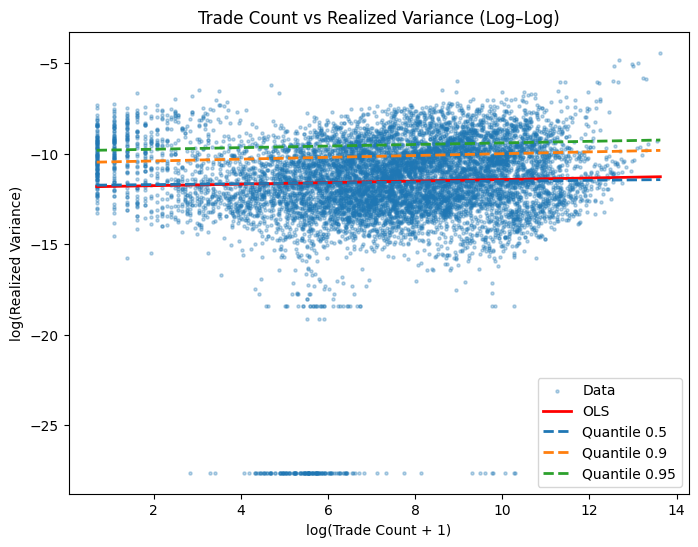

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(df["log_trade"], df["log_rv"], s=5, alpha=0.3, label="Data")

# OLS 拟合线
lag_value = df["log_rv_lag1"].mean()
x_grid = np.linspace(df["log_trade"].min(), df["log_trade"].max(), 200)

X_grid = pd.DataFrame({
    "const": 1.0,
    "log_trade": x_grid,
    "log_rv_lag1": lag_value
})
y_ols = ols_robust.predict(X_grid)

plt.plot(x_grid, y_ols, color="red", lw=2, label="OLS")

# Quantile lines
for q in quantiles:
    y_q = qr_results[q].params["const"] + qr_results[q].params["log_trade"] * x_grid + qr_results[q].params["log_rv_lag1"] * lag_value
    plt.plot(x_grid, y_q, lw=2, linestyle="--", label=f"Quantile {q}")

plt.xlabel("log(Trade Count + 1)")
plt.ylabel("log(Realized Variance)")
plt.legend()
plt.title("Trade Count vs Realized Variance (Log–Log)")
plt.show()

+ Minute Level

In [17]:
sql_query = f"""
SELECT
    CAST(symbol_id AS String) AS symbol_id,
    toStartOfMinute(toDateTime64(local_nanos, 9)) AS minute_ts,
    count() AS trade_count
FROM mdp__hk_alex.trade_record
PREWHERE
    create_sec >= toDateTime('{startdate.isoformat()}')
AND create_sec <  toDateTime('{enddate.isoformat()}')
GROUP BY
    symbol_id,
    minute_ts
ORDER BY
    symbol_id,
    minute_ts
"""
trade_nums = client_connect.query_df(sql_query)
trade_nums.head()

,symbol_id,minute_ts,trade_count
0,10405560964,2026-01-01 00:00:00,86
1,10405560964,2026-01-01 00:01:00,51
2,10405560964,2026-01-01 00:02:00,12
3,10405560964,2026-01-01 00:03:00,17
4,10405560964,2026-01-01 00:04:00,12


In [18]:
sql_query = f"""
WITH book_bbo AS
(
    SELECT
        CAST(symbol_id AS String) AS symbol_id,
        local_nanos,
        toStartOfMinute(toDateTime64(local_nanos, 9)) AS minute_ts,

        NULLIF(bids_prices[1], 0.0) AS bid_raw,
        NULLIF(asks_prices[1], 0.0) AS ask_raw
    FROM mdp__hk_alex.book_record
    PREWHERE
        create_sec >= toDateTime('{startdate.isoformat()}')
        AND create_sec <  toDateTime('{enddate.isoformat()}')
),

filled_bbo AS
(
    SELECT
        symbol_id,
        minute_ts,
        local_nanos,

        last_value(bid_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS bid_ff,

        last_value(ask_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ask_ff
    FROM book_bbo
),

mid_series AS
(
    SELECT
        symbol_id,
        minute_ts,
        local_nanos,
        (bid_ff + ask_ff) / 2.0 AS mid
    FROM filled_bbo
    WHERE
        bid_ff > 0
        AND ask_ff > 0
        AND bid_ff < ask_ff
),

rets AS
(
    SELECT
        symbol_id,
        minute_ts,
        local_nanos,
        log(mid) AS log_mid,

        /* minute 内相邻 log-return */
        log(mid) - lagInFrame(log(mid), 1)
            OVER (PARTITION BY symbol_id, minute_ts ORDER BY local_nanos) AS r
    FROM mid_series
)

SELECT
    symbol_id,
    minute_ts,

    /* std 口径 */
    stddevPop(log_mid) AS vol_log_std,

    /* realized variance / volatility */
    sumIf(r * r, isNotNull(r)) AS rv,
    sqrt(sumIf(r * r, isNotNull(r))) AS rv_sqrt,

    /* 质量检查 */
    count() AS num_book_samples,
    countIf(isNotNull(r)) AS num_returns

FROM rets
GROUP BY
    symbol_id,
    minute_ts
ORDER BY
    symbol_id,
    minute_ts
"""
vol_df = client_connect.query_df(sql_query)
vol_df.head()

,symbol_id,minute_ts,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
0,10405560964,2026-01-01 00:00:00,0.000080,8.615993e-08,0.000294,4224,4223
1,10405560964,2026-01-01 00:01:00,0.000219,3.992121e-08,0.000200,3252,3251
2,10405560964,2026-01-01 00:02:00,0.000057,2.756741e-08,0.000166,3648,3647
3,10405560964,2026-01-01 00:03:00,0.000100,2.494498e-08,0.000158,3612,3611
4,10405560964,2026-01-01 00:04:00,0.000012,5.746713e-09,0.000076,3452,3451


In [19]:
trade_nums.set_index(["symbol_id", 'minute_ts'], inplace=True)
vol_df.set_index(["symbol_id", 'minute_ts'], inplace=True)
merged_df = trade_nums.merge(vol_df, on=["symbol_id", 'minute_ts'], how='left')
merged_df.head()

trade_count  vol_log_std            rv  \
symbol_id   minute_ts                                                     
10405560964 2026-01-01 00:00:00           86     0.000080  8.615993e-08   
            2026-01-01 00:01:00           51     0.000219  3.992121e-08   
            2026-01-01 00:02:00           12     0.000057  2.756741e-08   
            2026-01-01 00:03:00           17     0.000100  2.494498e-08   
            2026-01-01 00:04:00           12     0.000012  5.746713e-09   

                                  rv_sqrt  num_book_samples  num_returns  
symbol_id   minute_ts                                                     
10405560964 2026-01-01 00:00:00  0.000294            4224.0       4223.0  
            2026-01-01 00:01:00  0.000200            3252.0       3251.0  
            2026-01-01 00:02:00  0.000166            3648.0       3647.0  
            2026-01-01 00:03:00  0.000158            3612.0       3611.0  
            2026-01-01 00:04:00  0.000076            3452.0       3451.0

In [20]:
merged_df.corr()

,trade_count,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
trade_count,1.000000,0.329954,0.412009,0.303611,0.531587,0.531587
vol_log_std,0.329954,1.000000,0.581037,0.825506,0.241904,0.241904
rv,0.412009,0.581037,1.000000,0.660811,0.123136,0.123136
rv_sqrt,0.303611,0.825506,0.660811,1.000000,0.185400,0.185400
num_book_samples,0.531587,0.241904,0.123136,0.185400,1.000000,1.000000
num_returns,0.531587,0.241904,0.123136,0.185400,1.000000,1.000000


In [21]:
EPS = 1e-12

df = merged_df[['trade_count', 'rv']].copy()

df["log_trade"] = np.log(df["trade_count"] + 1)
df["log_rv"] = np.log(df["rv"] + EPS)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df["log_rv_lag1"] = (
    df.groupby("symbol_id")["log_rv"]
      .shift(1)
)

df = df.dropna(subset=["log_rv_lag1"])

In [22]:
df

trade_count            rv  log_trade  \
symbol_id   minute_ts                                                   
10405560964 2026-01-01 00:01:00           51  3.992121e-08   3.951244   
            2026-01-01 00:02:00           12  2.756741e-08   2.564949   
            2026-01-01 00:03:00           17  2.494498e-08   2.890372   
            2026-01-01 00:04:00           12  5.746713e-09   2.564949   
            2026-01-01 00:05:00          310  3.446561e-07   5.739793   
...                                      ...           ...        ...   
12631097985 2026-01-12 13:47:00            2  5.184941e-06   1.098612   
            2026-01-12 17:26:00            3  2.004370e-05   1.386294   
            2026-01-12 18:59:00            2  6.885728e-07   1.098612   
            2026-01-12 19:07:00            1  7.941538e-06   0.693147   
            2026-01-12 23:10:00            1  2.883699e-06   0.693147   

                                    log_rv  log_rv_lag1  
symbol_id   minute_ts                                    
10405560964 2026-01-01 00:01:00 -17.036333   -16.267049  
            2026-01-01 00:02:00 -17.406595   -17.036333  
            2026-01-01 00:03:00 -17.506553   -17.406595  
            2026-01-01 00:04:00 -18.974464   -17.506553  
            2026-01-01 00:05:00 -14.880716   -18.974464  
...                                    ...          ...  
12631097985 2026-01-12 13:47:00 -12.169752   -10.634050  
            2026-01-12 17:26:00 -10.817596   -12.169752  
            2026-01-12 18:59:00 -14.188643   -10.817596  
            2026-01-12 19:07:00 -11.743403   -14.188643  
            2026-01-12 23:10:00 -12.756436   -11.743403  

[314183 rows x 5 columns]

In [23]:
import statsmodels.api as sm

X = df[["log_trade", "log_rv_lag1"]]
X = sm.add_constant(X)
y = df["log_rv"]

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 2.004e+05
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:41:20   Log-Likelihood:            -6.9746e+05
No. Observations:              314183   AIC:                         1.395e+06
Df Residuals:                  314180   BIC:                         1.395e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.5599      0.023   -246.636      

In [24]:
ols_robust = sm.OLS(y, X).fit(cov_type="HC3")
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 6.413e+04
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:41:20   Log-Likelihood:            -6.9746e+05
No. Observations:              314183   AIC:                         1.395e+06
Df Residuals:                  314180   BIC:                         1.395e+06
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.5599      0.038   -145.132      

In [25]:
from statsmodels.regression.quantile_regression import QuantReg

quantiles = [0.5, 0.9, 0.95]
qr_results = {}

for q in quantiles:
    qr = QuantReg(y, X)
    res = qr.fit(q=q)
    qr_results[q] = res
    print(f"\nQuantile {q}")
    print(res.summary())


Quantile 0.5
                         QuantReg Regression Results                          
Dep. Variable:                 log_rv   Pseudo R-squared:               0.4405
Model:                       QuantReg   Bandwidth:                     0.06640
Method:                 Least Squares   Sparsity:                        2.199
Date:                Tue, 13 Jan 2026   No. Observations:               314183
Time:                        09:41:21   Df Residuals:                   314180
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8569      0.011   -166.904      0.000      -1.879      -1.835
log_trade       0.0967      0.001     93.992      0.000       0.095       0.099
log_rv_lag1     0.9062      0.001   1527.133      0.000       0.905       0.907

Quantile 0.9
                   

In [26]:
summary_table = pd.DataFrame({
    "quantile": quantiles,
    "beta_log_trade": [qr_results[q].params["log_trade"] for q in quantiles],
    "beta_log_rv_lag1": [qr_results[q].params["log_rv_lag1"] for q in quantiles],
    "p_value": [qr_results[q].pvalues["log_trade"] for q in quantiles],
    "p_rv_lag1": [qr_results[q].pvalues["log_rv_lag1"] for q in quantiles],
})

summary_table

,quantile,beta_log_trade,beta_log_rv_lag1,p_value,p_rv_lag1
0,0.50,0.096694,0.906180,0.0,0.0
1,0.90,0.186680,0.411310,0.0,0.0
2,0.95,0.215789,0.331576,0.0,0.0


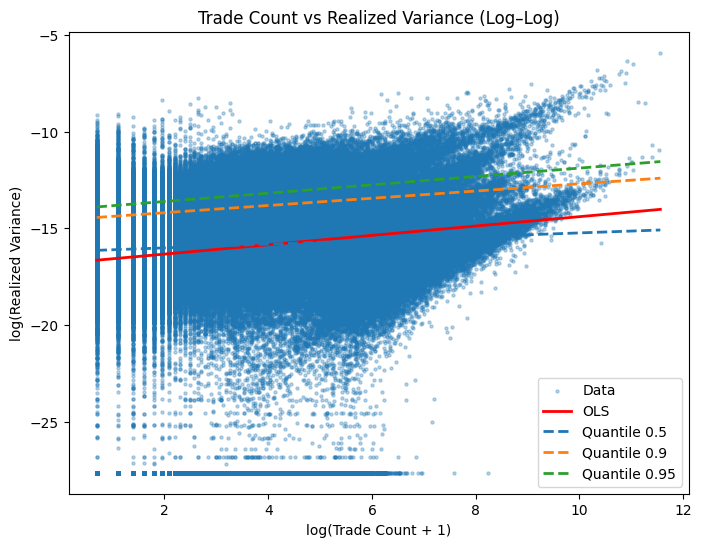

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(df["log_trade"], df["log_rv"], s=5, alpha=0.3, label="Data")

# OLS 拟合线
lag_value = df["log_rv_lag1"].mean()
x_grid = np.linspace(df["log_trade"].min(), df["log_trade"].max(), 200)

X_grid = pd.DataFrame({
    "const": 1.0,
    "log_trade": x_grid,
    "log_rv_lag1": lag_value
})
y_ols = ols_robust.predict(X_grid)

plt.plot(x_grid, y_ols, color="red", lw=2, label="OLS")

# Quantile lines
for q in quantiles:
    y_q = qr_results[q].params["const"] + qr_results[q].params["log_trade"] * x_grid + qr_results[q].params["log_rv_lag1"] * lag_value
    plt.plot(x_grid, y_q, lw=2, linestyle="--", label=f"Quantile {q}")

plt.xlabel("log(Trade Count + 1)")
plt.ylabel("log(Realized Variance)")
plt.legend()
plt.title("Trade Count vs Realized Variance (Log–Log)")
plt.show()

+ Second Level

In [5]:
sql_query = f"""
SELECT
    CAST(symbol_id AS String) AS symbol_id,
    toStartOfSecond(toDateTime64(local_nanos, 9)) AS second_ts,
    count() AS trade_count
FROM mdp__hk_alex.trade_record
PREWHERE
    create_sec >= toDateTime('{startdate.isoformat()}')
AND create_sec <  toDateTime('{enddate.isoformat()}')
GROUP BY
    symbol_id,
    second_ts
ORDER BY
    symbol_id,
    second_ts
"""
trade_nums = client_connect.query_df(sql_query)
trade_nums.head()

,symbol_id,second_ts,trade_count
0,10405560964,2026-01-01 00:00:00,1
1,10405560964,2026-01-01 00:00:02,1
2,10405560964,2026-01-01 00:00:04,1
3,10405560964,2026-01-01 00:00:06,2
4,10405560964,2026-01-01 00:00:07,10


In [6]:
sql_query = f"""
WITH book_bbo AS
(
    SELECT
        CAST(symbol_id AS String) AS symbol_id,
        local_nanos,
        toStartOfSecond(toDateTime64(local_nanos, 9)) AS second_ts,

        NULLIF(bids_prices[1], 0.0) AS bid_raw,
        NULLIF(asks_prices[1], 0.0) AS ask_raw
    FROM mdp__hk_alex.book_record
    PREWHERE
        create_sec >= toDateTime('{startdate.isoformat()}')
        AND create_sec <  toDateTime('{enddate.isoformat()}')
),

filled_bbo AS
(
    SELECT
        symbol_id,
        second_ts,
        local_nanos,

        last_value(bid_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS bid_ff,

        last_value(ask_raw) IGNORE NULLS
            OVER (PARTITION BY symbol_id ORDER BY local_nanos
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ask_ff
    FROM book_bbo
),

mid_series AS
(
    SELECT
        symbol_id,
        second_ts,
        local_nanos,
        (bid_ff + ask_ff) / 2.0 AS mid
    FROM filled_bbo
    WHERE
        bid_ff > 0
        AND ask_ff > 0
        AND bid_ff < ask_ff
),

rets AS
(
    SELECT
        symbol_id,
        second_ts,
        local_nanos,
        log(mid) AS log_mid,

        /* minute 内相邻 log-return */
        log(mid) - lagInFrame(log(mid), 1)
            OVER (PARTITION BY symbol_id, second_ts ORDER BY local_nanos) AS r
    FROM mid_series
)

SELECT
    symbol_id,
    second_ts,

    /* std 口径 */
    stddevPop(log_mid) AS vol_log_std,

    /* realized variance / volatility */
    sumIf(r * r, isNotNull(r)) AS rv,
    sqrt(sumIf(r * r, isNotNull(r))) AS rv_sqrt,

    /* 质量检查 */
    count() AS num_book_samples,
    countIf(isNotNull(r)) AS num_returns

FROM rets
GROUP BY
    symbol_id,
    second_ts
ORDER BY
    symbol_id,
    second_ts
"""
vol_df = client_connect.query_df(sql_query)
vol_df.head()

,symbol_id,second_ts,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
0,10405560964,2026-01-01 00:00:00,0.000000e+00,0.0,0.0,71,70
1,10405560964,2026-01-01 00:00:01,3.046401e-07,0.0,0.0,49,48
2,10405560964,2026-01-01 00:00:02,0.000000e+00,0.0,0.0,90,89
3,10405560964,2026-01-01 00:00:03,2.313000e-07,0.0,0.0,68,67
4,10405560964,2026-01-01 00:00:04,0.000000e+00,0.0,0.0,71,70


In [7]:
trade_nums.set_index(["symbol_id", 'second_ts'], inplace=True)
vol_df.set_index(["symbol_id", 'second_ts'], inplace=True)
merged_df = trade_nums.merge(vol_df, on=["symbol_id", 'second_ts'], how='left')
merged_df.head()

trade_count  vol_log_std            rv  \
symbol_id   second_ts                                                     
10405560964 2026-01-01 00:00:00            1     0.000000  0.000000e+00   
            2026-01-01 00:00:02            1     0.000000  0.000000e+00   
            2026-01-01 00:00:04            1     0.000000  0.000000e+00   
            2026-01-01 00:00:06            2     0.000000  0.000000e+00   
            2026-01-01 00:00:07           10     0.000064  1.021122e-08   

                                  rv_sqrt  num_book_samples  num_returns  
symbol_id   second_ts                                                     
10405560964 2026-01-01 00:00:00  0.000000              71.0         70.0  
            2026-01-01 00:00:02  0.000000              90.0         89.0  
            2026-01-01 00:00:04  0.000000              71.0         70.0  
            2026-01-01 00:00:06  0.000000              98.0         97.0  
            2026-01-01 00:00:07  0.000101             100.0         99.0

In [8]:
merged_df.corr()

,trade_count,vol_log_std,rv,rv_sqrt,num_book_samples,num_returns
trade_count,1.000000,0.317349,0.308195,0.308192,0.295658,0.295658
vol_log_std,0.317349,1.000000,0.503843,0.899297,0.272969,0.272969
rv,0.308195,0.503843,1.000000,0.590624,0.074856,0.074856
rv_sqrt,0.308192,0.899297,0.590624,1.000000,0.257114,0.257114
num_book_samples,0.295658,0.272969,0.074856,0.257114,1.000000,1.000000
num_returns,0.295658,0.272969,0.074856,0.257114,1.000000,1.000000


/home/gshe/anaconda3/envs/FinRL/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


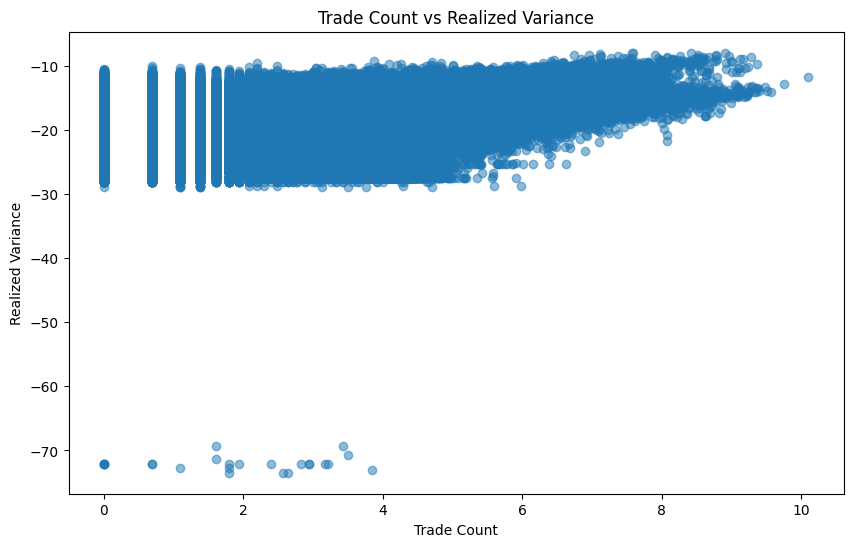

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(merged_df['trade_count']), np.log(merged_df['rv']), alpha=0.5)
plt.xlabel('Trade Count')
plt.ylabel('Realized Variance')
plt.title('Trade Count vs Realized Variance')
plt.show()

In [10]:
EPS = 1e-12

df = merged_df[['trade_count', 'rv']].copy()

df["log_trade"] = np.log(df["trade_count"] + 1)
df["log_rv"] = np.log(df["rv"] + EPS)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df["log_rv_lag1"] = (
    df.groupby("symbol_id")["log_rv"]
      .shift(1)
)

df = df.dropna(subset=["log_rv_lag1"])

In [11]:
df

trade_count            rv  log_trade  \
symbol_id   second_ts                                                   
10405560964 2026-01-01 00:00:02            1  0.000000e+00   0.693147   
            2026-01-01 00:00:04            1  0.000000e+00   0.693147   
            2026-01-01 00:00:06            2  0.000000e+00   1.098612   
            2026-01-01 00:00:07           10  1.021122e-08   2.397895   
            2026-01-01 00:00:11           11  1.293916e-08   2.484907   
...                                      ...           ...        ...   
12631097985 2026-01-12 13:47:14            1  1.284986e-06   0.693147   
            2026-01-12 17:26:22            3  9.934808e-06   1.386294   
            2026-01-12 18:59:06            2  3.364051e-07   1.098612   
            2026-01-12 19:07:56            1  6.382601e-06   0.693147   
            2026-01-12 23:10:04            1  1.929300e-06   0.693147   

                                    log_rv  log_rv_lag1  
symbol_id   second_ts                                    
10405560964 2026-01-01 00:00:02 -27.631021   -27.631021  
            2026-01-01 00:00:04 -27.631021   -27.631021  
            2026-01-01 00:00:06 -27.631021   -27.631021  
            2026-01-01 00:00:07 -18.399680   -27.631021  
            2026-01-01 00:00:11 -18.162930   -18.399680  
...                                    ...          ...  
12631097985 2026-01-12 13:47:14 -13.564762   -18.371388  
            2026-01-12 17:26:22 -11.519466   -13.564762  
            2026-01-12 18:59:06 -14.904947   -11.519466  
            2026-01-12 19:07:56 -11.961935   -14.904947  
            2026-01-12 23:10:04 -13.158353   -11.961935  

[6401017 rows x 5 columns]

In [12]:
import statsmodels.api as sm

X = df[["log_trade", "log_rv_lag1"]]
X = sm.add_constant(X)
y = df["log_rv"]

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                 2.179e+06
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:46:17   Log-Likelihood:            -1.7841e+07
No. Observations:             6401017   AIC:                         3.568e+07
Df Residuals:                 6401014   BIC:                         3.568e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.0969      0.008  -2147.501      

In [13]:
ols_robust = sm.OLS(y, X).fit(cov_type="HC3")
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                 3.364e+06
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:46:18   Log-Likelihood:            -1.7841e+07
No. Observations:             6401017   AIC:                         3.568e+07
Df Residuals:                 6401014   BIC:                         3.568e+07
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.0969      0.009  -1829.127      

In [14]:
from statsmodels.regression.quantile_regression import QuantReg

quantiles = [0.5, 0.9, 0.95]
qr_results = {}

for q in quantiles:
    qr = QuantReg(y, X)
    res = qr.fit(q=q)
    qr_results[q] = res
    print(f"\nQuantile {q}")
    print(res.summary())


Quantile 0.5
                         QuantReg Regression Results                          
Dep. Variable:                 log_rv   Pseudo R-squared:               0.3393
Model:                       QuantReg   Bandwidth:                     0.04771
Method:                 Least Squares   Sparsity:                       0.8230
Date:                Tue, 13 Jan 2026   No. Observations:              6401017
Time:                        09:46:56   Df Residuals:                  6401014
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.5496      0.001  -7853.113      0.000      -6.551      -6.548
log_trade       0.9369      0.000   6530.936      0.000       0.937       0.937
log_rv_lag1     0.8002   3.21e-05   2.49e+04      0.000       0.800       0.800

Quantile 0.9
                   

In [15]:
summary_table = pd.DataFrame({
    "quantile": quantiles,
    "beta_log_trade": [qr_results[q].params["log_trade"] for q in quantiles],
    "beta_log_rv_lag1": [qr_results[q].params["log_rv_lag1"] for q in quantiles],
    "p_value": [qr_results[q].pvalues["log_trade"] for q in quantiles],
    "p_rv_lag1": [qr_results[q].pvalues["log_rv_lag1"] for q in quantiles],
})

summary_table

,quantile,beta_log_trade,beta_log_rv_lag1,p_value,p_rv_lag1
0,0.50,0.936891,0.800214,0.0,0.0
1,0.90,1.014458,0.240440,0.0,0.0
2,0.95,0.898696,0.189482,0.0,0.0


/home/gshe/anaconda3/envs/FinRL/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


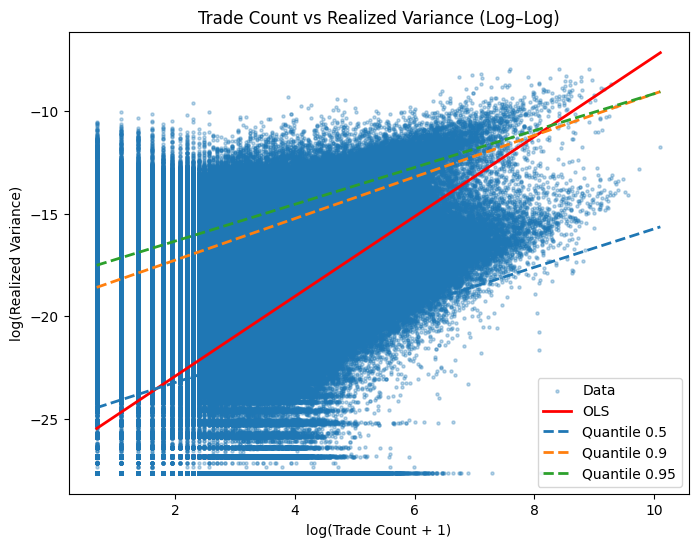

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(df["log_trade"], df["log_rv"], s=5, alpha=0.3, label="Data")

# OLS 拟合线
lag_value = df["log_rv_lag1"].mean()
x_grid = np.linspace(df["log_trade"].min(), df["log_trade"].max(), 200)

X_grid = pd.DataFrame({
    "const": 1.0,
    "log_trade": x_grid,
    "log_rv_lag1": lag_value
})
y_ols = ols_robust.predict(X_grid)

plt.plot(x_grid, y_ols, color="red", lw=2, label="OLS")

# Quantile lines
for q in quantiles:
    y_q = qr_results[q].params["const"] + qr_results[q].params["log_trade"] * x_grid + qr_results[q].params["log_rv_lag1"] * lag_value
    plt.plot(x_grid, y_q, lw=2, linestyle="--", label=f"Quantile {q}")

plt.xlabel("log(Trade Count + 1)")
plt.ylabel("log(Realized Variance)")
plt.legend()
plt.title("Trade Count vs Realized Variance (Log–Log)")
plt.show()

trade_count            rv  log_trade  \
symbol_id   second_ts                                                   
10405560964 2026-01-01 00:00:02            1  0.000000e+00   0.693147   
            2026-01-01 00:00:04            1  0.000000e+00   0.693147   
            2026-01-01 00:00:06            2  0.000000e+00   1.098612   
            2026-01-01 00:00:07           10  1.021122e-08   2.397895   
            2026-01-01 00:00:11           11  1.293916e-08   2.484907   
...                                      ...           ...        ...   
12631097985 2026-01-11 15:49:22            1  4.857515e-07   0.693147   
            2026-01-11 18:19:44            2  0.000000e+00   1.098612   
            2026-01-11 21:04:29            2  2.474540e-08   1.098612   
            2026-01-11 22:16:53            1  7.590653e-06   0.693147   
            2026-01-11 22:16:54            1  3.352018e-07   0.693147   

                                    log_rv  log_rv_lag1  
symbol_id   second_ts                                    
10405560964 2026-01-01 00:00:02 -27.631021   -27.631021  
            2026-01-01 00:00:04 -27.631021   -27.631021  
            2026-01-01 00:00:06 -27.631021   -27.631021  
            2026-01-01 00:00:07 -18.399680   -27.631021  
            2026-01-01 00:00:11 -18.162930   -18.399680  
...                                    ...          ...  
12631097985 2026-01-11 15:49:22 -14.537567   -19.127348  
            2026-01-11 18:19:44 -27.631021   -14.537567  
            2026-01-11 21:04:29 -17.514586   -27.631021  
            2026-01-11 22:16:53 -11.788593   -17.514586  
            2026-01-11 22:16:54 -14.908530   -11.788593  

[5319778 rows x 5 columns]

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.925e+06
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:21:55   Log-Likelihood:            -1.4760e+07
No. Observations:             5319778   AIC:                         2.952e+07
Df Residuals:                 5319775   BIC:                         2.952e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.0031      0.009  -1949.825      

                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 2.956e+06
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:21:56   Log-Likelihood:            -1.4760e+07
No. Observations:             5319778   AIC:                         2.952e+07
Df Residuals:                 5319775   BIC:                         2.952e+07
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.0031      0.010  -1636.498      


Quantile 0.5
                         QuantReg Regression Results                          
Dep. Variable:                 log_rv   Pseudo R-squared:               0.3364
Model:                       QuantReg   Bandwidth:                     0.04660
Method:                 Least Squares   Sparsity:                       0.7646
Date:                Mon, 12 Jan 2026   No. Observations:              5319778
Time:                        15:22:30   Df Residuals:                  5319775
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.2313      0.001  -7250.554      0.000      -6.233      -6.230
log_trade       0.8733      0.000   5911.930      0.000       0.873       0.874
log_rv_lag1     0.8092   3.28e-05   2.47e+04      0.000       0.809       0.809

Quantile 0.9
                   

,quantile,beta_log_trade,p_value
0,0.50,0.873341,0.0
1,0.90,1.088080,0.0
2,0.95,0.936553,0.0


/home/gshe/anaconda3/envs/FinRL/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


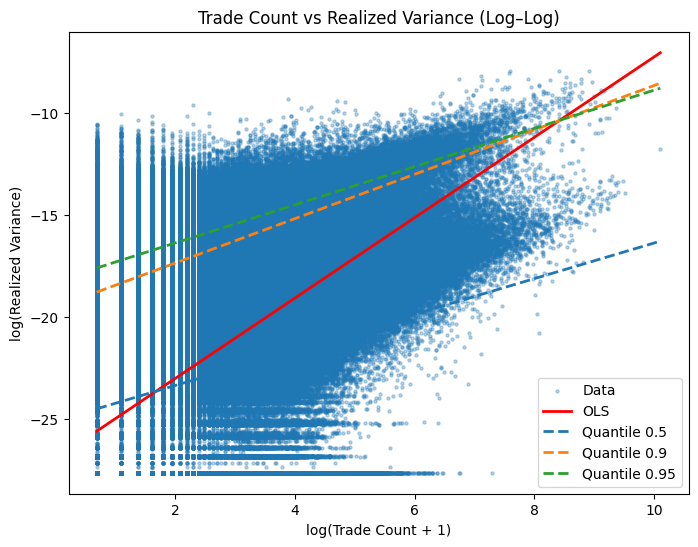